In [1]:
import sys,os,glob

In [2]:
sys.path.append('/home/simon/git/pymzm')
sys.path.append('/home/simon/git/mass-spec-utils')

In [3]:
condition = 1
ion_mode = 'Pos'

In [4]:
mzml_folder = '/home/simon/data/lipid_files/lipid_files/Condition_{}/{}/'.format(condition,ion_mode)
pp_folder = os.path.join(mzml_folder,'picked_peaks')

In [52]:
mzml_file_list = glob.glob(os.path.join(mzml_folder,'*.mzML'))

pos = mzml_file_list.index('/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/24_pp_s3_pos_1.mzML')
del mzml_file_list[pos]
mzml_pp = []
for m in mzml_file_list:
    final_part = m.split(os.sep)[-1]
    pp_name = final_part.split('.')[0] + '_box.csv'
    mzml_pp.append((m,os.path.join(pp_folder,pp_name)))
    
for m,p in mzml_pp:
    print(m,p)

/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/0_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/0_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/48_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/48_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/96_pp_d20_.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/96_pp_d20__box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/72_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/72_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/8_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/8_pp_d20_pos_1_box.csv


In [53]:
from ms2_matching import load_picked_boxes,MZMLFile

In [54]:
all_boxes = {}
for m,p in mzml_pp:
    all_boxes[p] = load_picked_boxes(p)

In [55]:
all_mzml_file_obj = {}
for m,p in mzml_pp:
    all_mzml_file_obj[p] = MZMLFile(m)

Loaded 1968 scans
Loaded 1968 scans
Loaded 1967 scans
Loaded 1968 scans
Loaded 1968 scans


In [56]:
from chromatograms import add_chromatograms_to_boxes
for p in all_boxes:
    add_chromatograms_to_boxes(all_boxes[p],all_mzml_file_obj[p])
    

In [57]:
def find_boxes(boxes,mz,rt_in_seconds,mz_tol = 0.01,rt_tol = 10):
    sub_boxes = list(filter(lambda x: abs(x.mz - mz) <= mz_tol and 
                            abs(x.rt_in_seconds - rt_in_seconds) <= rt_tol,boxes))
    return sub_boxes

In [58]:
# order files by time
ordered_files = list(all_boxes.keys())
ordered_files.sort(key = lambda x: int(x.split(os.sep)[-1].split('_')[0]))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PC 34:1 ('C42H82NO8P', 'C42H81DNO8P', 760.5836, 628.2, '[M+H]+')
PC 34:2 ('C42H80NO8P', 'C42H79DNO8P', 758.5677, 586.8, '[M+H]+')
PC 34:0 ('C42H84NO8P', 'C42H83DNO8P', 762.5997, 672.0, '[M+H]+')
[(762.6007321188208, 762.599365234375, 670.188), (762.6007321188208, 762.60009765625, 671.8199999999999)]


AssertionError: None

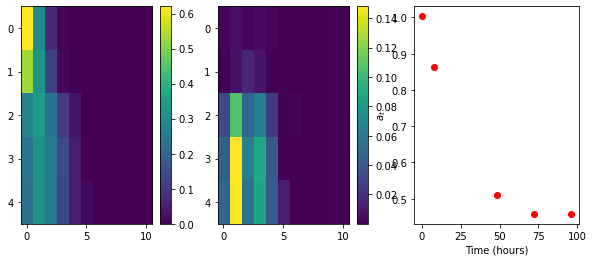

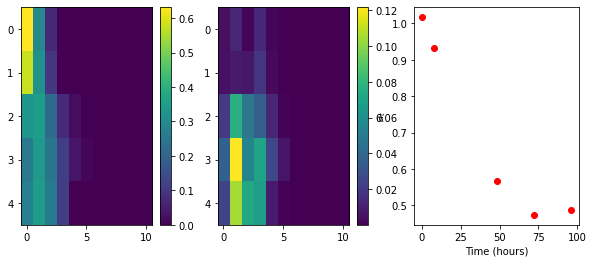

In [83]:
%load_ext autoreload
%autoreload 2
from molmass import Formula
from adduct_rules import AdductTransformer
import numpy as np
import pylab as plt
%matplotlib inline
at = AdductTransformer()
from chromatograms import peak_group
lipids = {'PC 34:1':('C42H82NO8P','C42H81DNO8P',760.5836,10.47*60,'[M+H]+'),
          'PC 34:2':('C42H80NO8P','C42H79DNO8P',758.5677,9.78*60.0,'[M+H]+'),
          'PC 34:0':('C42H84NO8P','C42H83DNO8P',762.5997,11.2*60.0,'[M+H]+')}
for lipid,dets in lipids.items():
    print(lipid,dets)
    f = Formula(dets[0])
#     print("Mono: ",f.isotope.mass)
    if ion_mode == 'Pos':
        mz = at.mass2ion(f.isotope.mass,dets[4])
    rt = dets[3]
#     print(mz,rt)
    
    
    normal_spec = f.spectrum()
    heavy_spec = Formula(dets[1]).spectrum()

    mz_vals = []
    x = []
    y = []
    for key,(m,i) in normal_spec.items():
        temp_mz = at.mass2ion(m,dets[4])
        mz_vals.append(int(temp_mz))
        x.append(i)
        y.append(heavy_spec.get(key,(0,0))[1])

    n_rows = len(ordered_files)
    n_cols = len(x)

    data_mat = np.zeros((n_rows,n_cols),np.double)

    for i,o in enumerate(ordered_files):
        l = find_boxes(all_boxes[o],mz,rt,rt_tol = 5)
        assert len(l) == 1,print([(mz,b.mz,b.rt_in_seconds) for b in l])
        g = peak_group(all_boxes[o],l[0],threshold = 0.75,max_mz_diff = 10)
#         print(len(g))
        
        
        for box in g:
            for j,m in enumerate(mz_vals):
                if int(box.mz) == m:
                    data_mat[i,j] = box.height
    data_mat /= data_mat.sum(axis=1)[:,None]
#     plt.imshow(data_mat,aspect='auto')
#     plt.colorbar()
    
    x = np.array(x)
    y = np.array(y)

    recon = []

    all_a = []
    for row in data_mat:
        f = row - y
        m = x-y
        a = ((f*m).sum())/((m*m).sum())
        all_a.append(a)
        recon.append(a*x + (1-a)*y)

    recon = np.array(recon)
    times = [int(x.split(os.sep)[-1].split('_')[0]) for x in ordered_files]

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(data_mat,aspect='auto')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(np.abs(data_mat - recon),aspect='auto')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.plot(times,all_a,'ro')
    plt.xlabel('Time (hours)')
    plt.ylabel('$a_t$')


    